#Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.stats import norm
import math
import statsmodels.api as sm

In [ ]:
data_natixis = pd.read_csv('Natixis stock (dataset TD12).txt', delimiter="\t", header=None)
print(data_natixis.shape)

(1023, 2)


#Data processing

In [ ]:
data_natixis = data_natixis.rename(columns={0:"date",1:"stock_value"})
data_natixis['date'] = pd.to_datetime(data_natixis['date'])
data_natixis["stock_value"] = data_natixis["stock_value"].str.replace(',', '.').astype(float)
stock_values = data_natixis['stock_value']
returns = np.zeros(len(stock_values))
for i in range(1, len(stock_values)):
    returns[i] = (stock_values[i] - stock_values[i-1]) / stock_values[i-1]
data_natixis['returns'] = returns
data_natixis['returns'] = data_natixis['returns'].round(5)

<ipython-input-3-ff178ec7ffbd>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data_natixis['date'] = pd.to_datetime(data_natixis['date'])


In [ ]:
data_natixis.head()

,date,stock_value,returns
0,2015-02-01,5.621,0.00000
1,2015-05-01,5.424,-0.03505
2,2015-06-01,5.329,-0.01751
3,2015-07-01,5.224,-0.01970
4,2015-08-01,5.453,0.04384


#Data visualization

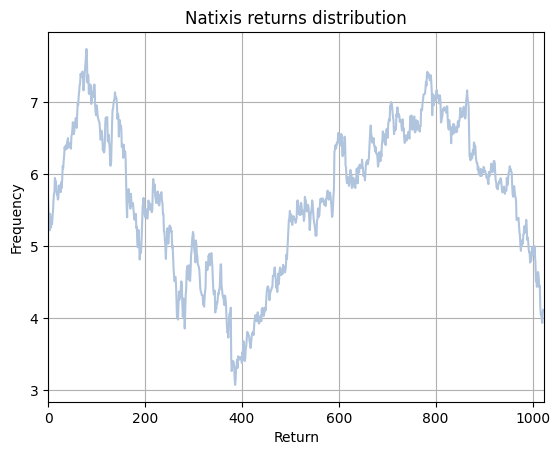

In [ ]:
plt.plot(data_natixis['stock_value'], color='lightsteelblue')
plt.title("Natixis returns distribution")
plt.xlabel("Return")
plt.grid(True)
plt.ylabel("Frequency")
plt.xlim(0,1024)
plt.show()

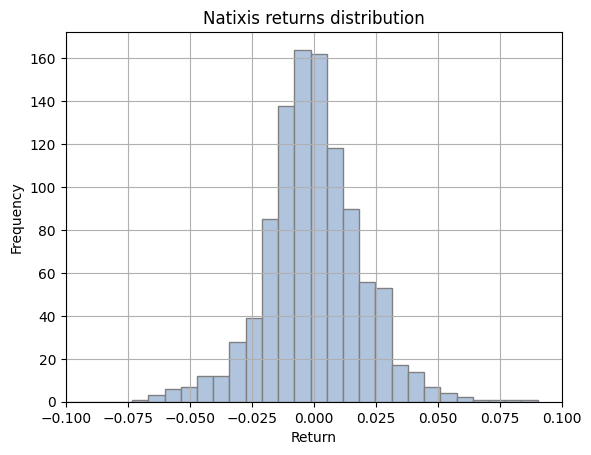

In [ ]:
plt.hist(data_natixis['returns'], bins=40, color='lightsteelblue', edgecolor="grey")
plt.title("Natixis returns distribution")
plt.xlim(-0.1,0.1)
plt.xlabel("Return")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

#Question A : Value at Risk

##1) Non parametric VaR

In [ ]:
data2015_2016 = data_natixis[(data_natixis["date"] >= datetime(2015,1,1)) & (data_natixis["date"] <= datetime(2016,12,31))]
rdt = data2015_2016['returns']

###a) Kernel pdf

In [ ]:
def get_scott_bandwidth(data, sigma):
    n = len(data)
    bandwidth = 1.06 * sigma * n**(-0.2)
    return bandwidth

In [ ]:
def biweight(u):
    return (15/16) * (1 - u**2)**2 * (np.abs(u) <= 1)

In [ ]:
def kernel_density_estimate(data, x, bandwidth):
    kernel_vals = 0
    for i in range(len(data)):
        kernel_vals += biweight((x - data.iloc[i]) / bandwidth)
    return kernel_vals / (len(data) * bandwidth)

In [ ]:
mean = round((np.sum(rdt))/len(rdt),5)
std = round(((np.sum((rdt - mean)**2))/(len(rdt)-1))**0.5,5)

In [ ]:
x_values = np.linspace(np.min(rdt)-0.1, np.max(rdt)+0.1, 1000)
scott_h = get_scott_bandwidth(rdt, std)
PDF = [kernel_density_estimate(rdt, x, scott_h) for x in x_values]

In [ ]:
print(scott_h)

0.0072602709985179


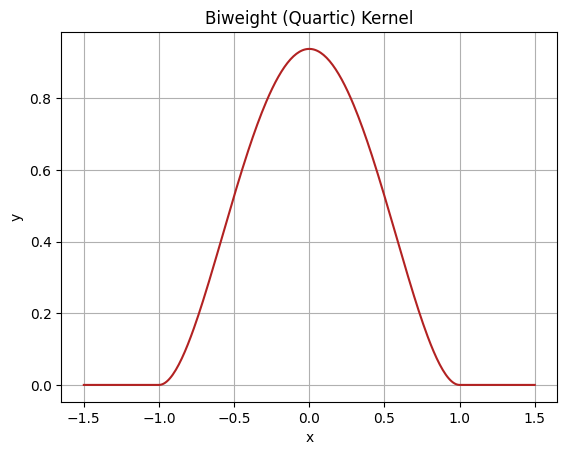

In [ ]:
kernel_bi = biweight(np.linspace(-1.5, 1.5, 300))
plt.plot(np.linspace(-1.5, 1.5, 300), kernel_bi, color='firebrick')
plt.title('Biweight (Quartic) Kernel')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

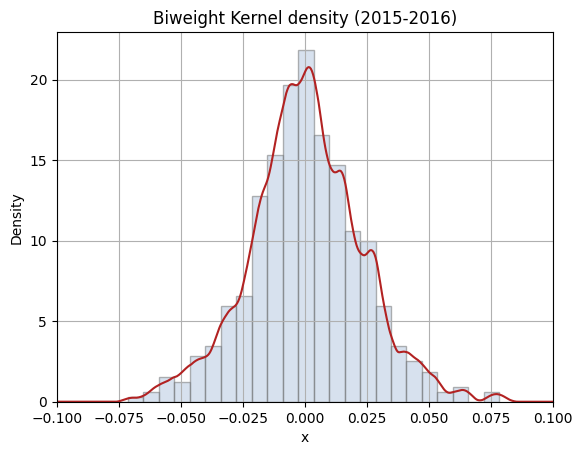

In [ ]:
plt.plot(x_values, PDF,color ='firebrick')
plt.hist(rdt, bins=40, density=True,edgecolor='dimgrey',label='gains',color='lightsteelblue',alpha=0.5)
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)
plt.title("Biweight Kernel density (2015-2016)")
plt.xlim(-0.10, 0.10)
plt.show()

###b) Kernel cdf

In [ ]:
integration_step = x_values[1] - x_values[0]
CDF = np.cumsum(PDF) * integration_step

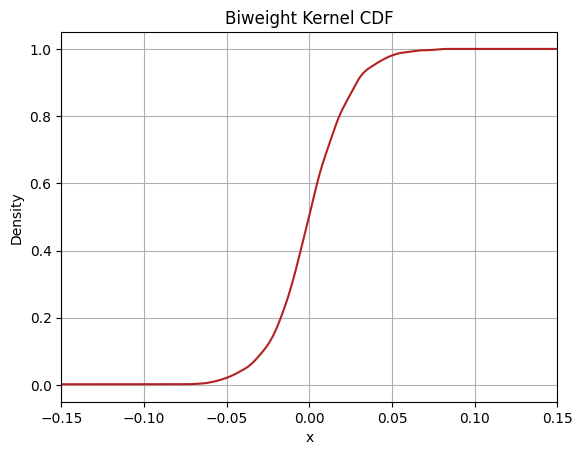

In [ ]:
plt.plot(x_values, CDF,color ='firebrick')
plt.xlabel('x')
plt.ylabel('Density')
plt.xlim(-0.15,0.15)
plt.grid(True)
plt.title("Biweight Kernel CDF")
plt.show()

###c) VaR calculation

In [ ]:
def get_Non_Param_VaR(data, alpha):
  min = np.argmin((CDF - alpha)**2)
  return round(x_values[min],5)

In [ ]:
Non_parametric_VaR = get_Non_Param_VaR(rdt, 0.05)
print("Non-parametric Value at Risk :",Non_parametric_VaR)

Non-parametric Value at Risk : -0.03812


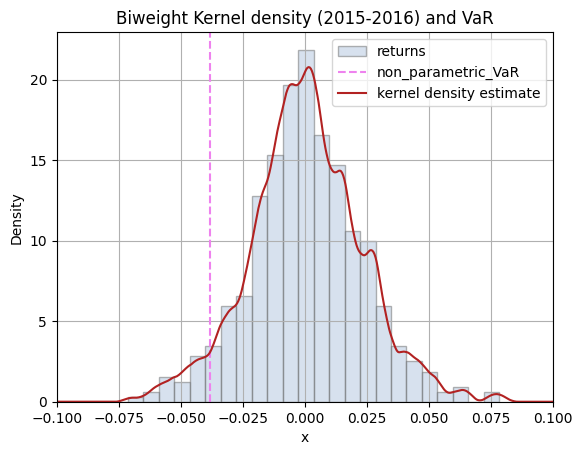

In [ ]:
plt.hist(rdt, bins=40, density=True,edgecolor='dimgrey',color='lightsteelblue',alpha=0.5, label="returns")
plt.axvline(Non_parametric_VaR, color='violet', linestyle='--', label='non_parametric_VaR')
plt.plot(x_values, PDF,color ='firebrick',label='kernel density estimate')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.title("Biweight Kernel density (2015-2016) and VaR")
plt.xlim(-0.10, 0.10)
plt.show()

##2) VaR validation

In [ ]:
data2017_2018 = data_natixis[(data_natixis['date'] >=  datetime(2017, 1, 1)) & (data_natixis['date'] <= datetime(2018, 12, 31))]
rdt2 = data2017_2018['returns']

###a) In sample

In [ ]:
NpVaR_exceeding = (rdt <= Non_parametric_VaR).sum()
NpVaR_proportion = round(NpVaR_exceeding  / len(rdt),4)
print("With Non-parametric VaR:")
print(NpVaR_exceeding," returns on ", len(rdt), " exceed the VaR threshold")
print("Corresponding to",round(NpVaR_proportion*100,5),"%, for a risk level of 5%")

With Non-parametric VaR:
26  returns on  513  exceed the VaR threshold
Corresponding to 5.07 %, for a risk level of 5%


###b) Out of sample

In [ ]:
mean2 = round((np.sum(rdt2))/len(rdt2),5)
std2 = round(((np.sum((rdt2 - mean2)**2))/(len(rdt2)-1))**0.5,5)
x_values2 = np.linspace(np.min(rdt2)-0.1, np.max(rdt2)+0.1, 1000)
scott_h = get_scott_bandwidth(rdt2, std2)
PDF2 = [kernel_density_estimate(rdt2, x, scott_h) for x in x_values2]

In [ ]:
NpVaR_exceeding2 = (rdt2 <= Non_parametric_VaR).sum()
NpVaR_proportion2 = round(NpVaR_exceeding2 / len(rdt2),4)
print("With Non-parametric VaR:")
print(NpVaR_exceeding2," returns on ", len(rdt2), " exceed the VaR threshold")
print("Corresponding to",round(NpVaR_proportion2*100,5),"%, for a risk level of 5%")

With Non-parametric VaR:
8  returns on  510  exceed the VaR threshold
Corresponding to 1.57 %, for a risk level of 5%


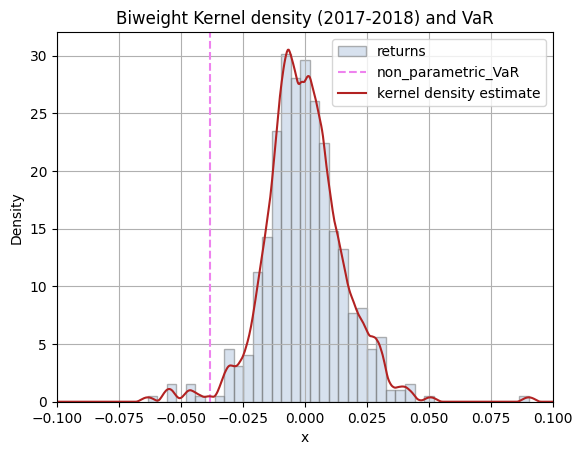

In [ ]:
plt.hist(rdt2, bins=40, density=True,edgecolor='dimgrey',color='lightsteelblue',alpha=0.5, label="returns")
plt.axvline(Non_parametric_VaR, color='violet', linestyle='--', label='non_parametric_VaR')
plt.plot(x_values2, PDF2,color ='firebrick',label='kernel density estimate')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.title("Biweight Kernel density (2017-2018) and VaR")
plt.xlim(-0.10, 0.10)
plt.show()

###c) Comparison

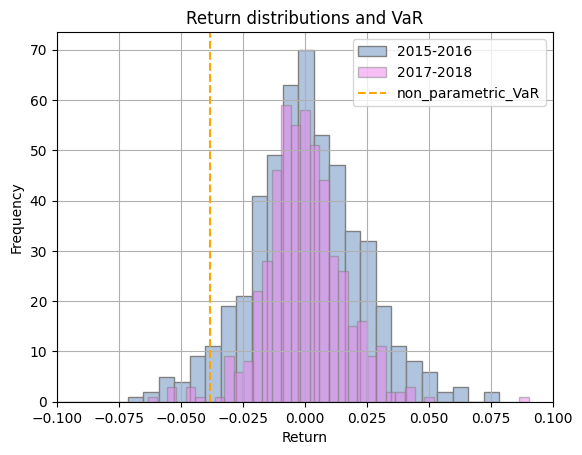

In [ ]:
plt.hist(rdt, bins=40, color='lightsteelblue', edgecolor="grey", label='2015-2016')
plt.hist(rdt2, bins=40, color='violet', alpha=0.5, edgecolor="grey", label='2017-2018')
plt.axvline(Non_parametric_VaR, color='orange', linestyle='--', label='non_parametric_VaR')
plt.title("Return distributions and VaR")
plt.xlim(-0.1,0.1)
plt.xlabel("Return")
plt.grid(True)
plt.legend()
plt.ylabel("Frequency")
plt.show()

#Question B : Expected Shorfall

In [ ]:
rdt_over_VaR = data2015_2016['returns'][data2015_2016['returns']<= Non_parametric_VaR]
ES = round(sum(rdt_over_VaR) / len(rdt_over_VaR),5)
print("Non parametric VaR :",Non_parametric_VaR)
print("The expected shorfall for the non_parametric VaR in sample (2015-2016) is : ",ES)

Non parametric VaR : -0.03812
The expected shorfall for the non_parametric VaR in sample (2015-2016) is :  -0.05336


#Question C : GEV

##1) Pickands estimator

###a)Gains and losses

We have to work on the two tails of the distribution so we will consider the gains and the losses.

For the negative returns (losses), we take the opposite in order to work only with positive values.

In [ ]:
gains = data_natixis['returns'][data_natixis['returns']>0]
losses = -data_natixis['returns'][data_natixis['returns']<0]
gains_sorted = sorted(gains)
losses_sorted = sorted(losses)
print(len(gains))
print(len(losses))
print(len(data_natixis['returns']))

498
519
1023


Let's plot the two series to check the distribution :

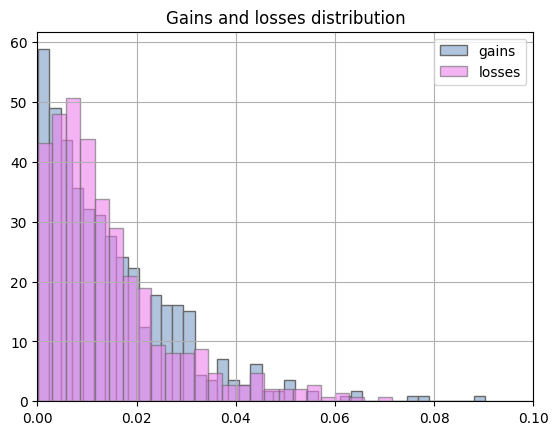

In [ ]:
plt.hist(gains_sorted, bins=40, density=True,edgecolor='dimgrey',label='gains',color='lightsteelblue')
plt.hist(losses_sorted, bins=60, density=True,edgecolor='dimgrey', label='losses', alpha=0.6, color="violet")
plt.title("Gains and losses distribution")
plt.xlim(0,0.1)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
len(gains)

498

###b) Estimator

In [ ]:
def pickands_estimator(data):
    n = len(data)
    k_n = np.log(n)
    x1 = data[n-math.floor(k_n)]
    x2 = data[n-2*math.floor(k_n)]
    x3 = data[n-4*math.floor(k_n)]
    pickands = (1/np.log(2)) * np.log((x1-x2)/(x2-x3))
    return round(pickands,3)

In [ ]:
pickands_gain = pickands_estimator(gains_sorted)
pickands_losses = pickands_estimator(losses_sorted)
print("Pickands estimator for extreme gain :", pickands_gain)
print("Pickands estimator for extreme losses :", pickands_losses)

Pickands estimator for extreme gain : 0.578
Pickands estimator for extreme losses : -0.512


###c) GEV of tail distributions

In [ ]:
def frechet_cdf(x, param):
  if x <= 0 :
    frechet = 0
  else :
    frechet = math.exp(-x**(-param))
  return frechet

In [ ]:
def weibull_cdf(x, param):
  if x <= 0 :
    weibull = math.exp(-(-x)**(param))
  else :
    weibull = 1
  return weibull

In [ ]:
x_values = np.linspace(-10,50,1000)
cdf_frechet = [frechet_cdf(x, pickands_gain) for x in x_values]
cdf_weibull = [weibull_cdf(x, pickands_losses) for x in x_values]

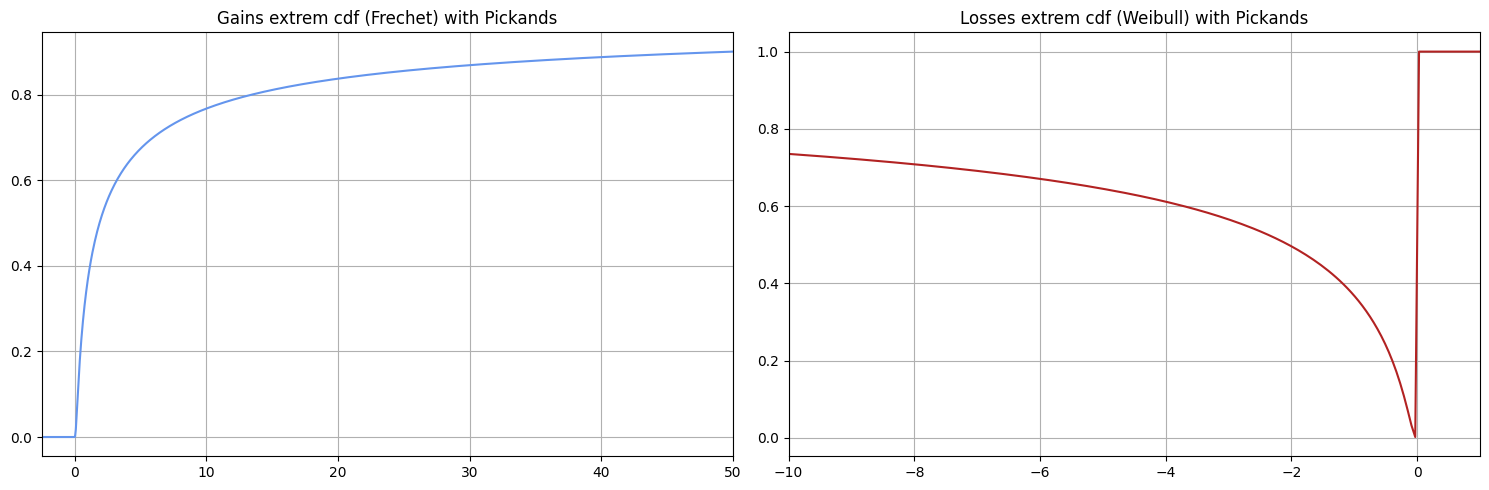

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(x_values, cdf_frechet,color ='cornflowerblue')
ax1.set_title("Gains extrem cdf (Frechet) with Pickands")
ax1.set_xlim(-2.5, 50)
ax1.grid(True)

ax2.plot(x_values, cdf_weibull,color ='firebrick')
ax2.set_title("Losses extrem cdf (Weibull) with Pickands")
ax2.set_xlim(-10, 1)
ax2.grid(True)

plt.tight_layout()
plt.show()

##2) GEV VaR

In [ ]:
def VaR_GEV_Pickands(data, level):
    n=len(data)
    pickands=np.abs(pickands_estimator(data))
    k_n = np.log(n)
    x1=data[n-math.floor(k_n)]
    x2=data[n-2*math.floor(k_n)]
    num=((1/(n*(1-level)))**pickands) - 1
    den=1-2**(-pickands)
    return round((num/den)*(x1-x2) + x1,5)

In [ ]:
VaR_GEV_P_gains = VaR_GEV_Pickands(gains_sorted, 0.95)
VaR_GEV_P_losses = VaR_GEV_Pickands(losses_sorted, 0.95)
print("GEV VaR at 95% for the gains :", VaR_GEV_P_gains)
print("GEV VaR at 95% for the losses :", VaR_GEV_P_losses)

GEV VaR at 95% for the gains : 0.03217
GEV VaR at 95% for the losses : 0.043


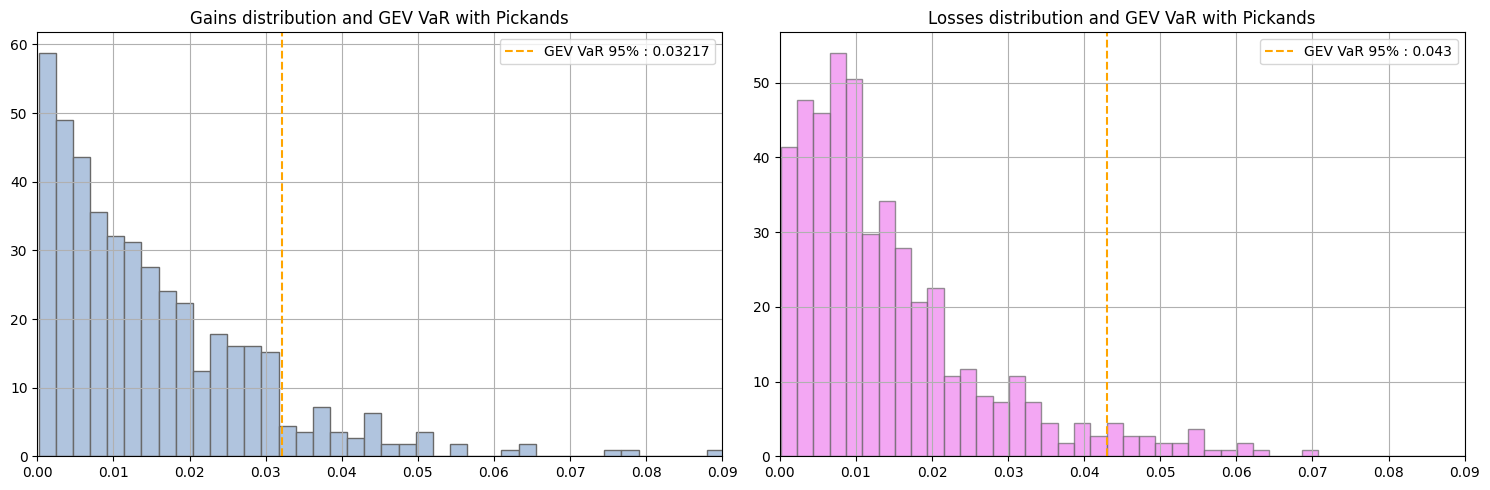

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(gains, bins=40, density=True,edgecolor='dimgrey', color='lightsteelblue')
ax1.set_title('Gains distribution and GEV VaR with Pickands')
ax1.axvline(VaR_GEV_P_gains, color="orange", linestyle="--",label=f"GEV VaR 95% : {VaR_GEV_P_gains}")
ax1.set_xlim(0,0.09)
ax1.grid(True)
ax1.legend()

ax2.hist(losses, bins=80, density=True,edgecolor='dimgrey', color='violet', alpha=0.7)
ax2.axvline(VaR_GEV_P_losses, color="orange", linestyle="--",label=f"GEV VaR 95% : {VaR_GEV_P_losses}")
ax2.set_title('Losses distribution and GEV VaR with Pickands')
ax2.set_xlim(0,0.09)
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
NpVaR_exceeding2 = (gains >= VaR_GEV_P_gains).sum()
NpVaR_proportion2 = round(NpVaR_exceeding2 / len(gains),5)
print("With Non-parametric VaR:")
print(NpVaR_exceeding2," returns on ", len(gains), " exceed the VaR threshold")
print("Corresponding to",round(NpVaR_proportion2*100,5),"%, for a risk level of 5%")

With Non-parametric VaR:
46  returns on  498  exceed the VaR threshold
Corresponding to 9.237 %, for a risk level of 5%


In [ ]:
NpVaR_exceeding2 = (losses >= VaR_GEV_P_losses).sum()
NpVaR_proportion2 = round(NpVaR_exceeding2 / len(losses),5)
print("With Non-parametric VaR:")
print(NpVaR_exceeding2," returns on ", len(gains), " exceed the VaR threshold")
print("Corresponding to",round(NpVaR_proportion2*100,5),"%, for a risk level of 5%")

With Non-parametric VaR:
26  returns on  498  exceed the VaR threshold
Corresponding to 5.01 %, for a risk level of 5%


#Question D

##1) Algrem & Chriss model parameters

In [35]:
data = pd.read_excel("Dataset TD4.xlsx")
data.rename(columns={"transaction date (1=1day=24 hours)": "Date",
                          "bid-ask spread": "Bid-Ask Spread",
                          "volume of the transaction (if known)": "Volume",
                          "Sign of the transaction": "Sign",
                          "Price (before transaction)": "Price"}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            1001 non-null   float64
 1   Bid-Ask Spread  1001 non-null   float64
 2   Volume          137 non-null    float64
 3   Sign            1001 non-null   int64  
 4   Price           1001 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 39.2 KB


In [36]:
import numpy as np
data.loc[data['Volume'] == '', 'Volume'] = np.nan

data['Volume'] = pd.to_numeric(data['Volume'])

length_data = len(data['Volume']) - 2

for i in range(length_data):
    if not (np.isnan(data['Volume'].iloc[i]) and data['Volume'].iloc[i] != 0):
        if np.isnan(data['Volume'].iloc[i + 1]):
            data.at[i + 1, 'Volume'] = 0
        if np.isnan(data['Volume'].iloc[i + 2]):
            data.at[i + 2, 'Volume'] = 0


data= data.dropna(subset=['Volume'])
dataVolume = data[data['Volume'] != 0].copy()
dataVolume.head()

,Date,Bid-Ask Spread,Volume,Sign,Price
0,0.000202,0.1100,8.0,-1,100.000
6,0.004074,0.1294,32.0,1,100.164
16,0.014393,0.1141,8.0,-1,100.048
28,0.022861,0.0978,141.0,-1,99.876
51,0.037864,0.1291,121.0,-1,99.608


###a) η

In [37]:

transientimpact = []
t = []

for i in range(len(dataVolume['Volume']) - 2):
    if dataVolume['Volume'].iloc[i] != 0:
        TI = dataVolume['Price'].iloc[i + 1] - dataVolume['Price'].iloc[i + 2] #Pt+1 - Pt+2
        transientimpact.append(TI)
        t.append(dataVolume['Date'].iloc[i + 2] - dataVolume['Date'].iloc[i + 1]) #diffence between two dates of Pt+1 - Pt+2

print(transientimpact) #transient impact


[0.11599999999999966, 0.17199999999999704, 0.2680000000000007, 0.29400000000001114, 0.05699999999998795, 0.13400000000000034, -0.03699999999999193, -0.10500000000000398, 0.02200000000000557, 0.05699999999998795, -0.4019999999999868, 0.012000000000000455, -0.11400000000000432, 0.20000000000000284, -0.48499999999999943, -0.25200000000000955, -0.013999999999995794, -0.09900000000000375, 0.034000000000006025, 0.046999999999997044, 0.049000000000006594, 0.018000000000000682, -0.007000000000005002, 1.0829999999999984, -0.10299999999999443, -0.11599999999999966, 0.03999999999999204, 0.07600000000000762, -0.13500000000000512, 0.06300000000000239, 0.08199999999999363, -0.013999999999995794, -0.20199999999999818, 0.06199999999999761, -0.0799999999999983, 0.01999999999999602, -0.11499999999999488, 0.05499999999999261, 0.012000000000000455, -0.02400000000000091, 0.029000000000010573, -0.14100000000000534, -0.14100000000000534, 0.14300000000000068, -0.117999999999995, -0.08899999999999864, 0.012000

In [38]:

Y = [] #NU * X = Y to solve the linear regression
for i in range(len(dataVolume['Volume']) - 2):
    Y.append(transientimpact[i] - (dataVolume['Bid-Ask Spread'].iloc[i]/2) * dataVolume['Sign'].iloc[i])
print(Y)

[0.17099999999999965, 0.10729999999999705, 0.32505000000000067, 0.34290000000001114, 0.12154999999998795, 0.17885000000000034, 0.011800000000008075, -0.154050000000004, -0.023399999999994432, 0.005349999999987948, -0.3538499999999868, -0.03804999999999954, -0.17015000000000433, 0.14760000000000284, -0.5362999999999994, -0.3087000000000095, -0.05389999999999579, -0.15290000000000376, -0.008899999999993975, 0.007049999999997045, 0.0967500000000066, 0.06360000000000068, -0.057450000000005004, 1.1294499999999985, -0.05364999999999443, -0.17314999999999967, 0.09464999999999205, 0.12250000000000762, -0.09500000000000511, 0.009150000000002385, 0.13364999999999364, -0.0673999999999958, -0.24514999999999817, 0.017749999999997615, -0.028599999999998293, 0.06354999999999603, -0.1703499999999949, 0.1099999999999926, -0.030949999999999547, 0.019949999999999093, -0.024299999999989427, -0.19725000000000534, -0.19665000000000535, 0.09450000000000068, -0.061299999999995, -0.04204999999999864, -0.036199

In [39]:
X = []
for i in range(len(dataVolume['Volume']) - 2):
    temp = dataVolume['Volume'].iloc[i] / t[i]

    X.append(temp)
print(X)



[775.2689214071132, 3778.9324515824283, 533.2266879957341, 17317.61238025056, 1247422.6804123728, 43280.182232346226, 19722.097714029587, 253658.53658536117, 174148.60681114532, 6800000.000002637, 5528.749497386406, 18093.587521663787, 50832.90400137378, 24539.877300613505, 29721.815519765787, 95283.9268527419, 41146.711635750486, 24969.549330085298, 46007.403490216726, 50000.00000000046, 21118.012422360243, 6286.186931348227, 4274.156617310334, 628.3775292195546, 32378.580323785878, 15319.865319865317, 62276.30637079414, 26678.141135972546, 93846.1538461535, 27729.865994427535, 75064.26735218501, 28684.47082096979, 8530.710558008832, 396588.48614070384, 89120.37037037285, 2168.9733526130913, 9499.882232864884, 1420.4545454545437, 1383.7638376383802, 13051.17926726949, 131.72627280511097, 20130.25458851396, 11120.61591103504, 3650.846332558926, 20022.342528143025, 22271.71492204895, 110236.22047244152, 4444.444444444452, 80208.9735709887, 638.1213706847046, 4565.112926477656, 2866.2420

In [40]:
def LinearRegression(x,y):
  num = np.sum((x-np.mean(x))*(y-np.mean(y)))
  den = np.sum((x-np.mean(x))**2)
  slope = num/den
  return slope

print("ŋ =", LinearRegression(X,Y))
nu =  LinearRegression(X,Y)


ŋ = -1.4168633631897502e-09


###b) σ

In [41]:
#compute the returns
dataVolume['return'] = pd.Series(index=dataVolume.index)
for i in range(1, len(dataVolume)):
  previous_price = dataVolume['Price'].iloc[i - 1]
  current_price = dataVolume['Price'].iloc[i]
  return_value = ((current_price - previous_price) / previous_price)# * (1/((dataVolume['Date'].iloc[i] -dataVolume['Date'].iloc[i-1])**(1/2))) #dont need to do that because we are with same time step
  dataVolume['return'].iloc[i] = return_value
print(dataVolume)

mean_return = sum(dataVolume['return'][1:]) / len(dataVolume['return']-1)
print("The mean return is ", mean_return)

squaredSum = 0
for i in range(2, len(dataVolume['return'])):
    squaredSum += ( dataVolume['return'].iloc[i] - mean_return) ** 2

sigma =(squaredSum / (len( dataVolume['return']) - 1))**(1/2)
print("The standard deviation is", sigma)





         Date  Bid-Ask Spread  Volume  Sign    Price    return
0    0.000202          0.1100     8.0    -1  100.000       NaN
6    0.004074          0.1294    32.0     1  100.164  0.001640
16   0.014393          0.1141     8.0    -1  100.048 -0.001158
28   0.022861          0.0978   141.0    -1   99.876 -0.001719
51   0.037864          0.1291   121.0    -1   99.608 -0.002683
..        ...             ...     ...   ...      ...       ...
988  0.968804          0.0896    14.0    -1  101.206  0.003132
989  0.969113          0.1105   150.0    -1  101.184 -0.000217
990  0.971882          0.0929    17.0    -1  101.083 -0.000998
996  0.981441          0.0834    79.0     1  101.070 -0.000129
999  0.991232          0.1153     3.0    -1  100.958 -0.001108

[137 rows x 6 columns]
The mean return is  7.157547543057469e-05
The standard deviation is 0.001991064949250777


<ipython-input-41-e7a164091634>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dataVolume['return'] = pd.Series(index=dataVolume.index)
<ipython-input-41-e7a164091634>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataVolume['return'].iloc[i] = return_value


###c) γ

In [42]:
permanentimpact = []
t = []
for i in range(len(dataVolume['Volume']) - 2):
      TI = dataVolume['Price'].iloc[i +2] - dataVolume['Price'].iloc[i] #Pt+2 - Pt
      permanentimpact.append(TI)
      t.append(dataVolume['Date'].iloc[i + 2] - dataVolume['Date'].iloc[i]) #difference between two dates of Pt+2 - Pt

print(permanentimpact)



[0.04800000000000182, -0.2879999999999967, -0.4399999999999977, -0.5620000000000118, -0.3509999999999991, -0.1909999999999883, -0.09700000000000841, 0.1419999999999959, 0.08299999999999841, -0.07899999999999352, 0.34499999999999886, 0.38999999999998636, 0.10200000000000387, -0.08599999999999852, 0.2849999999999966, 0.737000000000009, 0.26600000000000534, 0.11299999999999955, 0.06499999999999773, -0.08100000000000307, -0.09600000000000364, -0.06700000000000728, -0.01099999999999568, -1.0759999999999934, -0.980000000000004, 0.2189999999999941, 0.07600000000000762, -0.11599999999999966, 0.0589999999999975, 0.07200000000000273, -0.14499999999999602, -0.06799999999999784, 0.21599999999999397, 0.14000000000000057, 0.018000000000000682, 0.060000000000002274, 0.09499999999999886, 0.060000000000002274, -0.06699999999999307, 0.012000000000000455, -0.005000000000009663, 0.11199999999999477, 0.2820000000000107, -0.001999999999995339, -0.025000000000005684, 0.20699999999999363, 0.07699999999999818,

In [43]:
X = [] #gamma * X = Y here Y = permanent impact

for i in range(len(dataVolume['Volume']) - 2):
    temp = dataVolume['Volume'].iloc[i] / t[i]
    X.append(temp)
print(X)

[563.7375801564373, 1703.3054771916752, 340.846150568787, 6092.02851587816, 14686.24833110815, 41014.57096600107, 17039.73356052978, 4577.464788732394, 150300.60120240427, 52227.34254992329, 5523.197429202651, 10708.570959668486, 14618.727775582773, 2471.0424710424677, 27131.782945736475, 12581.01410598551, 30469.53046953041, 13122.099535925769, 24624.964619303697, 2748.625687156418, 19354.83870967743, 4491.725768321516, 2222.927913623373, 445.1368795904738, 8451.358254005108, 7871.291410777622, 11857.707509881406, 12114.107073075393, 58804.627249357254, 22030.146516285455, 15397.595443999171, 9810.55480378895, 7744.87471526197, 17828.045624460803, 57764.441110277534, 1991.27631329414, 5397.207725589896, 202.0338069903697, 1044.5682451253501, 8124.891184493066, 77.19027402547275, 3663.5957114379626, 5664.488017429192, 1687.1165644171783, 15904.436860068294, 4736.129905277406, 31724.450487196915, 3625.8158085569335, 29395.202162405592, 528.401585204755, 2024.3633909862565, 959.181498454

In [44]:
print("γ =", LinearRegression(X,permanentimpact))
gamma =  LinearRegression(X,permanentimpact)

γ = 2.714276160923749e-07


##2) Liquidation strategy

In [45]:
def calculate_xk(sigma, nu,lmbda):
    xk = np.zeros(24)
    M = np.sqrt(lmbda * (sigma**2) / abs(nu))
    if(lmbda==0):
      M = 0

    for i in range(24):
        xk[i] = (np.sinh(M*(24- (i - 1/2*1/24)))/np.sinh(M*24))*100000 # 100000 is the initial capital
    return xk
#define here lambda
lmbda = 0.9
xk = calculate_xk(sigma, mean_return, lmbda) #we put mean_return instead of nu
print(xk)


[100466.24368663  80362.07906547  64280.48437026  51416.48616161
  41126.16963637  32894.44710313  26309.27497261  21041.02867961
  16826.00313651  13453.212824    10753.83078989   8592.73791937
   6861.75947021   5474.25032404   4360.75791532   3465.54574337
   2743.80344982   2159.40381052   1683.09436659   1291.03317582
    963.5953906     684.39092492    439.44403925    216.49377681]


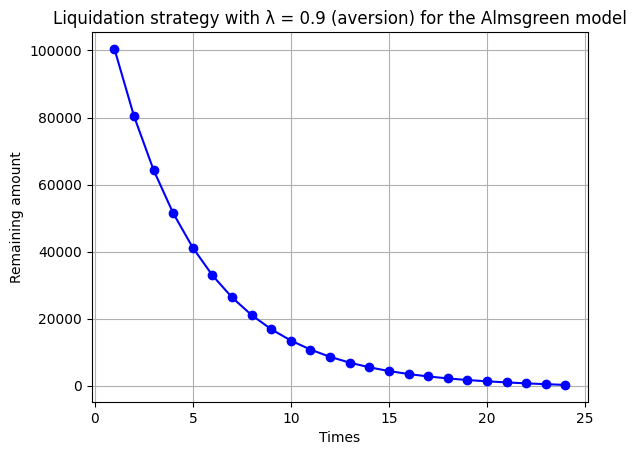

In [46]:
import matplotlib.pyplot as plt
plt.plot(range(1, 25), xk, 'bo-')
plt.xlabel('Times')
plt.ylabel('Remaining amount')
plt.title('Liquidation strategy with λ = '+ str(lmbda)+' (aversion) for the Almsgreen model')
plt.grid(True)
plt.show()

# Question E

In [ ]:
GBPEUR = pd.read_excel('Dataset TD5.xlsx', header=2, usecols="A:C", names=["Date", "High", "Low"])
SEKEUR = pd.read_excel('Dataset TD5.xlsx', header=2, usecols="E:G", names=["Date", "High", "Low"])
CADEUR = pd.read_excel('Dataset TD5.xlsx', header=2, usecols="I:K", names=["Date", "High", "Low"])

In [ ]:
def mid_prices(list_data):
  for data in list_data :
    data['Mid'] = (data['High'] + data['Low'])/2
    returns = np.zeros(len(data['Mid']))
    log_returns = np.zeros(len(data['Mid']))
    for i in range(1, len(data['Mid'])):
      returns[i] = (data['Mid'].iloc[i] - data['Mid'].iloc[i-1]) / data['Mid'].iloc[i-1]
      log_returns[i] = np.log(data['Mid'].iloc[i]/data['Mid'].iloc[i-1])
    data['Returns'] = returns
    data['Log_returns'] = log_returns

In [ ]:
mid_prices([GBPEUR, SEKEUR, CADEUR])

In [ ]:
GBPEUR.head()

,Date,High,Low,Mid,Returns,Log_returns
0,2016-03-07 08:59:59.990,1.2932,1.2917,1.29245,0.000000,0.000000
1,2016-03-07 09:15:00.000,1.2940,1.2930,1.29350,0.000812,0.000812
2,2016-03-07 09:30:00.000,1.2943,1.2922,1.29325,-0.000193,-0.000193
3,2016-03-07 09:45:00.000,1.2930,1.2913,1.29215,-0.000851,-0.000851
4,2016-03-07 10:00:00.000,1.2931,1.2921,1.29260,0.000348,0.000348


In [ ]:
SEKEUR.head()

,Date,High,Low,Mid,Returns,Log_returns
0,2016-03-07 08:59:59.990,0.10725,0.10720,0.107225,0.000000e+00,0.000000e+00
1,2016-03-07 09:15:00.000,0.10728,0.10717,0.107225,0.000000e+00,0.000000e+00
2,2016-03-07 09:30:00.000,0.10726,0.10719,0.107225,-1.294268e-16,-1.110223e-16
3,2016-03-07 09:45:00.000,0.10728,0.10721,0.107245,1.865237e-04,1.865063e-04
4,2016-03-07 10:00:00.000,0.10725,0.10719,0.107220,-2.331111e-04,-2.331383e-04


In [ ]:
CADEUR.head()

,Date,High,Low,Mid,Returns,Log_returns
0,2016-03-07 08:59:59.990,0.6842,0.6829,0.68355,0.000000,0.000000
1,2016-03-07 09:15:00.000,0.6849,0.6841,0.68450,0.001390,0.001389
2,2016-03-07 09:30:00.000,0.6844,0.6837,0.68405,-0.000657,-0.000658
3,2016-03-07 09:45:00.000,0.6844,0.6839,0.68415,0.000146,0.000146
4,2016-03-07 10:00:00.000,0.6840,0.6835,0.68375,-0.000585,-0.000585


##a) Covariance and Correlation

###1) Father and son wavelets

In [ ]:
def father_wavelet(x):
  if x >= 0 and x<1:
    father = 1
  else:
    father = 0
  return father

In [ ]:
def son_wavelet(x, k, j):
  return 2**(j/2) * father_wavelet((x * (2)**j) - k)

In [ ]:
x_values = np.linspace(-2,2,1000)
haar_father_wavelet = [father_wavelet(x) for x in x_values]
haar_son_wavelet = [son_wavelet(x, 0.75, 0) for x in x_values]
haar_son_wavelet2 = [son_wavelet(x, 0, 1) for x in x_values]
haar_son_wavelet3 = [son_wavelet(x, 0, -0.5) for x in x_values]

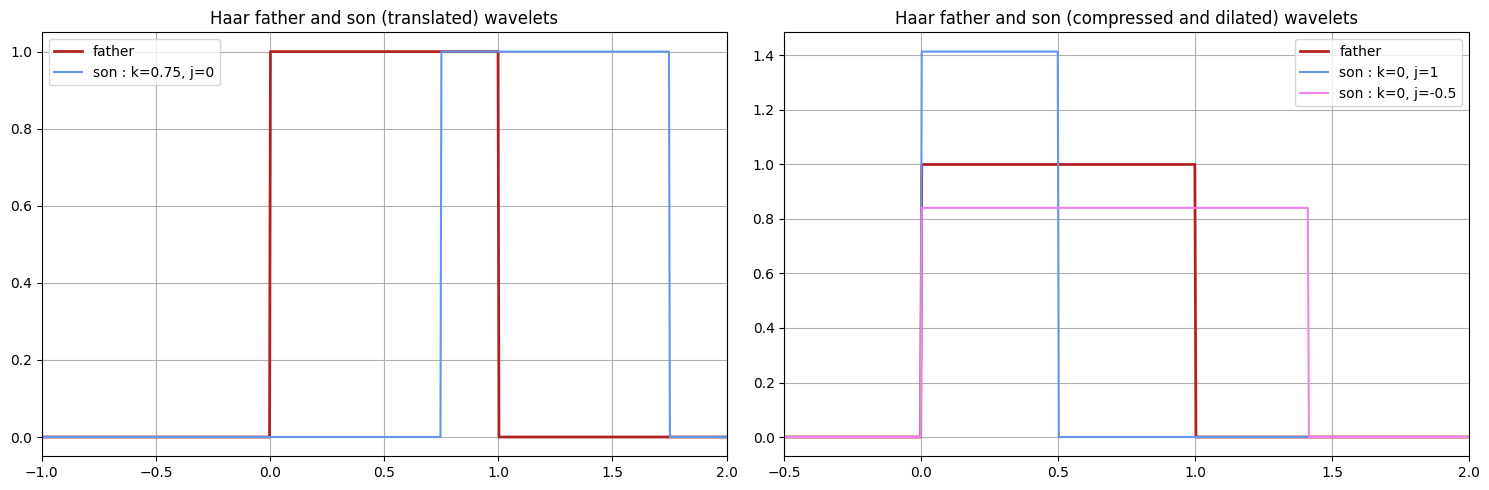

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(x_values, haar_father_wavelet, color='firebrick', linewidth=2, label='father')
ax1.plot(x_values, haar_son_wavelet, color='cornflowerblue', label='son : k=0.75, j=0')
ax1.set_title('Haar father and son (translated) wavelets')
ax1.set_xlim(-1,2)
ax1.legend()
ax1.grid(True)

ax2.plot(x_values, haar_father_wavelet, color='firebrick', linewidth=2, label='father')
ax2.plot(x_values, haar_son_wavelet2, color='cornflowerblue', label='son : k=0, j=1')
ax2.plot(x_values, haar_son_wavelet3, color='violet', label='son : k=0, j=-0.5')
ax2.set_title('Haar father and son (compressed and dilated) wavelets')
ax2.legend()
ax2.set_xlim(-0.5,2)
ax2.grid(True)

plt.tight_layout()
plt.show()

###2) Scale coefficient, Covariance and Correlation

In [ ]:
def coefficient_c(signal, j, k):
    return sum(son_wavelet(i, k, j) * signal[::(2**j)][i]for i in range(int(len(signal)/(2**j))))

In [ ]:
def cov(j, signal1, signal2):
  T = len(signal1)
  cov = 0
  division = int(T/(2**j))
  for i in range(division):
    m1 = sum(coefficient_c(signal1,j,k) for k in range(division))/division
    m2 = sum(coefficient_c(signal2,j,k) for k in range(division))/division
    cov += (coefficient_c(signal1,j,i) - m1) * (coefficient_c(signal2,j,i) - m2)
  return cov/division

In [ ]:
def correlation(j, signal1, signal2):
  covariance = cov(j, signal1, signal2)
  v1 = cov(j, signal1, signal1)
  v2 = cov(j, signal2, signal2)
  return covariance / ((v1**0.5) * (v2**0.5))

###3) Covariance and Correlation matrices


In [ ]:
def cov_matrix(j, signaux):
  cov_matrix = np.zeros((3, 3))
  for i in range(3):
    for k in range(3):
      cov_matrix[i,k] = cov(j, signaux[i], signaux[k])
  return cov_matrix

In [ ]:
def correl_matrix(j, signaux):
  correl_matrix = np.zeros((3, 3))
  for i in range(3):
    for k in range(3):
      correl_matrix[i,k] = correlation(j, signaux[i], signaux[k])
  return correl_matrix

###4) Hurst Exponent and volatility

We calculate the Hurst exponent thanks to the second order moment for the signal and the signal with another scale :

In [ ]:
def hurst_exponent(signal):
  M1 = np.mean((abs(signal[1:]-signal[:-1]))**2)
  M2 = np.mean((abs(signal[2:]-signal[:-2]))**2)
  return round(0.5*math.log2(M2/M1),5)

In [ ]:
print(hurst_exponent(GBPEUR['Mid'].values))
print(hurst_exponent(SEKEUR['Mid'].values))
print(hurst_exponent(CADEUR['Mid'].values))

0.67955
0.66729
0.66774


Now that we defined the Hurst exponent for each FX rate, we can transpose the volatility from the smallest internal (j=0) to another scalre :

In [ ]:
def vol_vector(j, signal1, signal2, signal3):
  v1 = (cov(j, signal1, signal1))**0.5
  v2 = (cov(j, signal2, signal2))**0.5
  v3 = (cov(j, signal3, signal3))**0.5
  return [v1,v2,v3]

In [ ]:
def transpose_vol(j, signal1, signal2, signal3):
  volatilities = (vol_vector(j, signal1, signal2, signal3))
  h1 = hurst_exponent(signal1)
  h2 = hurst_exponent(signal2)
  h3 = hurst_exponent(signal3)
  return [volatilities[1] * 2**(h1*j), volatilities[2] * 2**(h2*j), volatilities[3] * 2**(h3*j)]

###5)Volatility of the portfolio

In [ ]:
weights = np.array([1/3, 1/3, 1/3])

In [ ]:
cov_m = cov_matrix(0, [GBPEUR['Returns'].tolist(), SEKEUR['Returns'].tolist(), CADEUR['Returns'].tolist()])

KeyboardInterrupt: ignored

In [ ]:
vol_portfolio = (weights@cov_m@weights.T)**0.5

##b) Empirical volatility of the portfolio

###1) Returns of the portfolio

First let's create the portfolio midprices (assuming the weight of each FX rate is equal) :

In [ ]:
portfolio = pd.DataFrame(columns=["MidPrices","Returns"])
portfolio["MidPrices"] = GBPEUR['Mid']*1/3 + SEKEUR['Mid']*1/3 + CADEUR['Mid']*1/3
portfolio.head()

,MidPrices,Returns
0,0.694408,NaN
1,0.695075,NaN
2,0.694842,NaN
3,0.694515,NaN
4,0.694523,NaN


Then we'll calculate the returns of the portfolio at the smallest scale (j=0, one return every 15 min):

In [ ]:
mid = portfolio["MidPrices"]
returns = np.zeros(len(mid))
for i in range(1, len(mid)):
    returns[i] = (mid[i] - mid[i-1]) / mid[i-1]
portfolio["Returns"] = returns

In [ ]:
portfolio.head()

,MidPrices,Returns
0,0.694408,0.000000
1,0.695075,0.000960
2,0.694842,-0.000336
3,0.694515,-0.000470
4,0.694523,0.000012


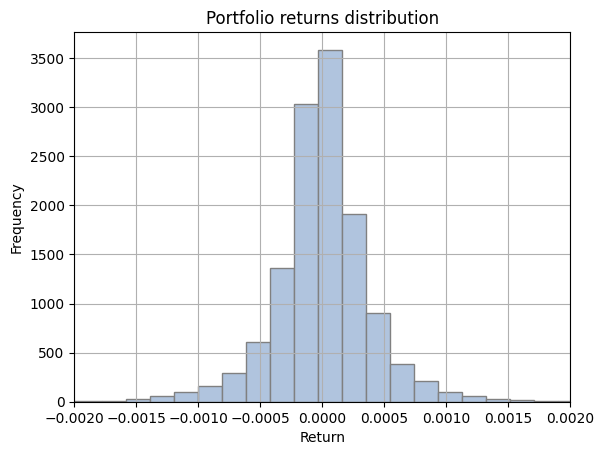

In [ ]:
plt.hist(portfolio["Returns"] , bins=80, color='lightsteelblue', edgecolor="grey")
plt.title("Portfolio returns distribution")
plt.xlim(-0.002,0.002)
plt.xlabel("Return")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

###2) Volatility of the Portfolio at scale j

The idea is to calculate the volatility of the portfolio for each scale j. To do that, we need the returns at the smallest scale (j=0) and we will compute the returns at the scale j wanted by taking a step of 2^j. When there is no dilatation : j=0 and 2^j = 1 so we take every returns. When j=1, 2^j=2 so we take one return over two, etc.

Then we simply calculate the volatility at the wanted scale j :


In [ ]:
def vol_j(j, returns):
  rdt = returns[::(2**j)].tolist()
  n = len(rdt)
  mean = sum(rdt)/len(rdt)
  std = (sum((rdt[i] - mean)**2 for i in range(n))/n) ** 0.5
  return std

Let's store the volatilities in a DataFrame for j from 0 (15 min) to 480 (5 days = 1 market week) :

In [ ]:
stds = pd.DataFrame(columns=["j","std"])
stds['j'] = [i for i in range(480)]
stds['std'] = [vol_j(i, portfolio["Returns"]) for i in range(480)]
stds.head(-10)

,j,std
0,0,0.000457
1,1,0.000461
2,2,0.000478
3,3,0.000472
4,4,0.000440
...,...,...
465,465,0.000000
466,466,0.000000
467,467,0.000000
468,468,0.000000
